# lmax vs time

In [2]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.style
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
mpl.style.use('ggplot')
print(mpl.style.available)

import cunusht

epsilons = [1e-14,1e-12,1e-10,1e-08,1e-06]#,1e-12,1e-10,1e-08,1e-06,1e-04,1e-02]
runs = np.arange(1,11)
lmaxs = np.array([256*n-1 for n in np.arange(1,21)])
blacklist_CPU, blacklist_GPU = [], []

def lmax2npoints(lmax):
    return (2*lmax)**2

def flatten_extend(matrix):
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return flat_list

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']
[SHTns 3.6.6] built Apr  8 2024, 07:59:49, id: v3.6.6-10-g3986338*,avx512,ishioka,openmp


## lenmap2gclm

In [42]:
popstr_runinfos_CPU = [
    ["CPU_Lenspyx_transformer"],
    ["init"],
    ["lenmap2gclm"],
    ["adjointsynthesisgeneral"],
    ["setup"],
    ["plane", "SphereInterpol setup", "borders"],
    ["dlm2pointing", "dlm2pointing - allocation", "dlm2pointing - dlm scaling"],
    ["pointing"],
    ["spin-1 synth"],
    # ["nuFFT2d2", "C2C", "synthesis"],
    # ["nuFFT2d2", "C2C", "doubling", "synthesis"],
    ["rotation", "rotate"],
    ["Transfers ->", "Transfer <-"],
]

planned = "planned"
popstrCPU = flatten_extend(popstr_runinfos_CPU)

runinfo = ('CPU', 'lenspyx')
blacklist_runinfos = []
dirnames = os.path.dirname(cunusht.__file__)[:-8]+'/test/benchmark/timings/{}/{}/'
fns = dirnames.format("CPU_Lenspyx_transformer", "lenmap2gclm") + "lmax{lmax}_epsilon{epsilon:1.0e}_run{run:02d}"

_ = []
print(f"searching for all files with epsilon in " + ",".join([f"{ep:1.0e}" for ep in epsilons])+" and lmax in " + ",".join([f"{lm}" for lm in lmaxs])+"")
for epsilon in epsilons:
    for lmax in lmaxs:
        for run in runs:
            fn = fns.format(backend=runinfo[0], solver=runinfo[1], lmax=lmax, epsilon=epsilon, planned=planned, run=run)
            if not os.path.isfile(fn):
                print(f"couldnt find {fn}")
                blacklist_runinfos.append(lmax)
if len(blacklist_runinfos)>0:
    print(f"Not found: {blacklist_runinfos}")
else:
    print("All files found")
    
print("Loading files")
dataCPU = []
for epsilon in epsilons:
    _ = []
    for lmax in lmaxs:
        if lmax not in blacklist_runinfos:
            mergedict = {}
            for run in runs:
                fn = fns.format(backend=runinfo[0], solver=runinfo[1], lmax=lmax, epsilon=epsilon, planned=planned, run=run)
                with open(fn, "r") as file:
                    newdict = json.load(file)
                    for key in newdict.keys():
                        if key in mergedict:
                            mergedict[key] = mergedict[key] + [newdict[key]]
                        else:
                            mergedict[key] = [newdict[key]]
            _.append(mergedict)
        else:
            print(f"not appending {lmax} to {runinfo}")
    dataCPU.append(_)
    print(len(dataCPU[0]), len(_))
    print(epsilon, np.mean(dataCPU[-1][-1]['nuFFT2d1']))
    # print(_)
# print(np.mean(dataCPU[0][-1]['nuFFT2d2']), np.mean(dataCPU[1][-1]['nuFFT2d2']))

for epsiloni, epsilon in enumerate(epsilons):
    popstr = popstrCPU
    for popstring in popstr:
        for d in dataCPU[epsiloni]:
            if popstring in d:
                d.pop(popstring)
    # print(epsilon, dataCPU[epsiloni])
          
ressCPU = []
keysCPU = np.array(list(dataCPU[0][0].keys()))[[0,2,1,3]]
for epsiloni, epsilon in enumerate(epsilons):
    data_across_lCPU = {}
    for d in dataCPU[epsiloni]:
        for keyi, key in enumerate(d.keys()):
            if key in data_across_lCPU:
                data_across_lCPU[key].append(d[key])
            else:
                data_across_lCPU[key] = [d[key]]
    _ = np.array([v for k, v in data_across_lCPU.items()])
    ressCPU.append(_)
    # print(epsilon, ressCPU[-1])
# print(ressCPU)
ressCPU = np.array(ressCPU)
print(ressCPU.shape, "epsilon, keys, lmax")

searching for all files with epsilon in 1e-14,1e-12,1e-10,1e-08,1e-06 and lmax in 255,511,767,1023,1279,1535,1791,2047,2303,2559,2815,3071,3327,3583,3839,4095,4351,4607,4863,5119
All files found
Loading files
20 20
1e-14 0.9430499999999998
20 20
1e-12 0.58221
20 20
1e-10 0.6728400000000001
20 20
1e-08 0.52478
20 20
1e-06 0.45315000000000005
(5, 4, 20, 10) epsilon, keys, lmax


(20, 5)


Text(0, 0.5, 'Total execution time / [s]')

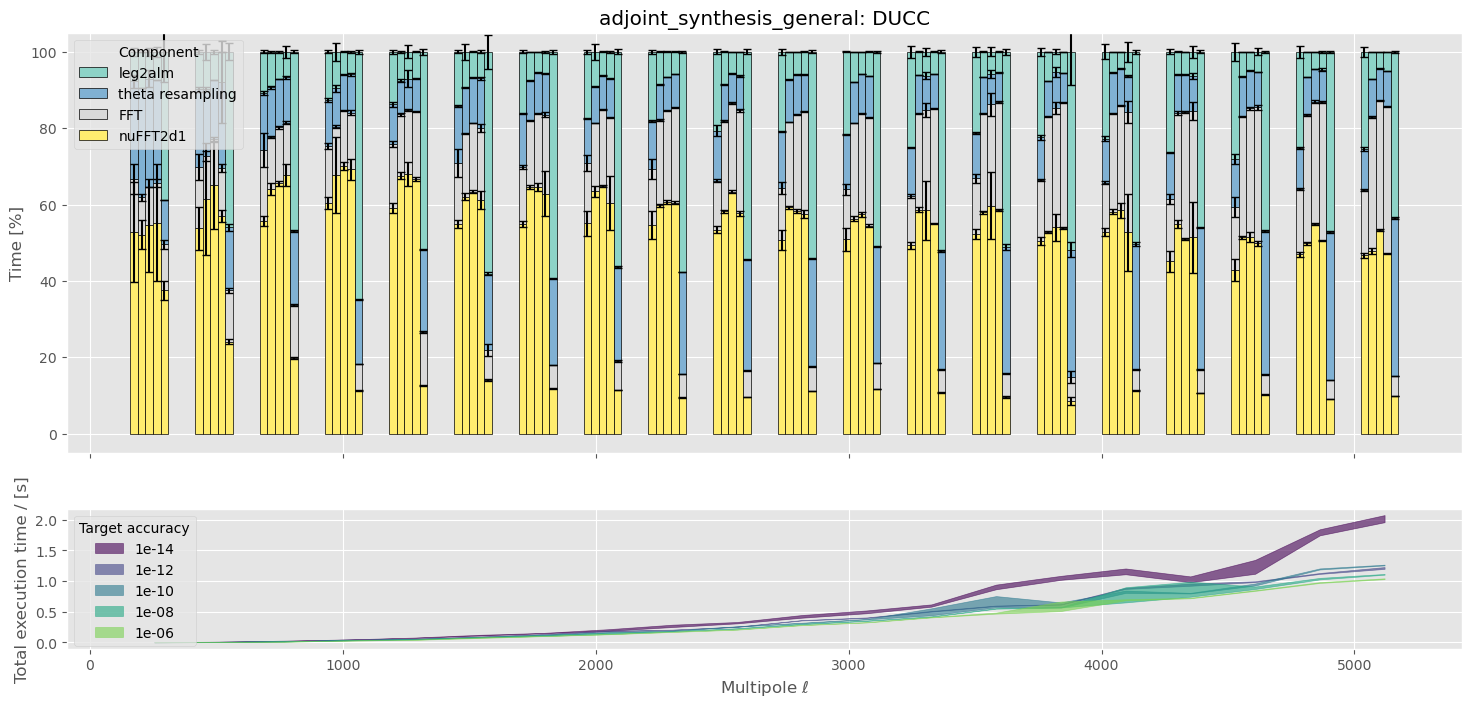

In [44]:
runinfo = ('CPU', 'lenspyx')

colors = plt.cm.Set3(np.linspace(0,1.0,len(keysCPU)))[::-1]
# For comparison with lenspyx, must sum over all rows
fig, ax = plt.subplots(2,1,figsize=(18,8), sharex=True, sharey=False, gridspec_kw={'height_ratios': [3, 1]})
for ressacci, (ressacc, errs) in enumerate(zip(np.mean(ressCPU,axis=-1), np.std(ressCPU,axis=-1))):
    total = np.sum(ressacc, axis=0)
    bottom = np.zeros(shape=(len(lmaxs)))
    for rowi, (row, err) in enumerate(zip(ressacc[[0,2,1,3]], errs[[0,2,1,3]])):
        ax[0].bar((lmaxs+ressacci*30-len(epsilons)//2*40), row/total*100, 30, align='center', bottom=bottom, yerr=err/total*100, capsize=3, label=list(keysCPU)[rowi] if ressacci==0 else "", edgecolor='black', color=colors[rowi])
        bottom += row/total*100

ax[0].set_title("adjoint_synthesis_general: DUCC".format(runinfo[0], runinfo[1]))
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles[::-1], labels[::-1], title='Component', loc='upper left')
# ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha='center')

# ax[0].set_yticklabels(np.arange(0,110,10))
from matplotlib.ticker import MaxNLocator
# ax[0].yaxis.set_major_locator(MaxNLocator(integer=True))
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
ax[0].set_ylim(-5, 105)
ax[0].yaxis.set_major_locator(MultipleLocator(20))
ax[0].yaxis.set_major_formatter('{x:.0f}')

# ax[0].set_xlabel('Multipole $\ell$')
ax[0].set_ylabel('Time [%]')

resi=0
accuracies = np.array([1/10**(n) for n in np.arange(14,3,-1)])
lmax_acc_time = np.array([[0. for a in range(len(lmaxs))] for n in range(len(epsilons))]).T
lmax_acc_time_err = np.array([[0. for a in range(len(lmaxs))] for n in range(len(epsilons))]).T


for ni, n in enumerate(range(lmax_acc_time.shape[-1])):
    lmax_acc_time[:,n] = np.sum(np.mean(ressCPU,axis=-1)[ni], axis=0)
    lmax_acc_time_err[:,n] = np.sum(np.std(ressCPU,axis=-1)[ni], axis=0)
    # print(np.sum(np.mean(ressCPU,axis=-1)[ni], axis=0))
# lmax_acc_time[:,-7] = np.sum(ress[resi], axis=0)*1.1
print(lmax_acc_time.shape)
# ax[1].set_xticklabels(accuracies, rotation=40, ha='center')

colors = plt.cm.viridis(np.linspace(0,0.8,len(epsilons)))
for acc_datai, acc_data in enumerate(lmax_acc_time.T):
    ax[1].fill_between(lmaxs, acc_data-lmax_acc_time_err.T[acc_datai], acc_data+lmax_acc_time_err.T[acc_datai], alpha=0.6, color=colors[acc_datai], label=f'{epsilons[acc_datai]}')
    # ax[1].plot(epsilons, acc_data, label=f'{lmaxs[::-1][acc_datai]}', color=colors[acc_datai], lw=3)
    
# ax[1].legend(title=r'$\ell_{\rm max}$')
ax[1].legend(title='Target accuracy', loc='upper left')

ax[1].set_xlabel('Accuracy') 
ax[1].set_xlabel('Multipole $\ell$')    
ax[1].set_ylabel('Total execution time / [s]')
# ax[1].set_xscale('log')
# ax[1].set_yscale('log')

#### GPU

In [6]:
lmaxsGPU = np.array([256*n-1 for n in np.arange(1,21)])

popstr_runinfos_GPU = [
    ["GPU_cufinufft_transformer"],
    ["init - setup", "init - deflectionlib", "init - SHTlib", "init - allocation", "init - weights", "nuFFT and C2C - plan", "init"],
    ["lenmap2gclm"],
    ["adjointsynthesisgeneral"],
    ["setup"],
    ["nuFFT - init", "nuFFT - plan"],
    # ['nuFFT - exec', 'nuFFT - set points']
    ["dlm2pointing"],
    ["pointing"],
    ["spin-1 synth"],
    ["ascontiguousarray"],
    # ["nuFFT2d2", "C2C", "synthesis"],
    # ["nuFFT2d2", "C2C", "doubling", "synthesis"],
    # ["doubling"],
    ["rotation", "rotate"],
    ["Transfer ->", "Transfer <-"],
]

runinfo = ('GPU', 'cufinufft')
blacklist_runinfos = []
planned = "planned"
popstrGPU = flatten_extend(popstr_runinfos_GPU)
dirnames = os.path.dirname(cunusht.__file__)[:-8]+'/test/benchmark/timings/{}/{}/'
fns = dirnames.format("GPU_cufinufft_transformer", "lenmap2gclm") + "lmax{lmax}_epsilon{epsilon:1.0e}_run{run:02d}"
dataGPU = []
epsilonsGPU = [1e-14, 1e-12]# 1e-10, 1e-08, 1e-06]

_ = []
print(f"searching for all files with epsilon in " + ",".join([f"{ep:1.0e}" for ep in epsilons])+" and lmax in " + ",".join([f"{lm}" for lm in lmaxs])+"")
for epsilon in epsilonsGPU:
    for lmax in lmaxsGPU:
        for run in runs:
            fn = fns.format(backend=runinfo[0], solver=runinfo[1], lmax=lmax, epsilon=epsilon, planned=planned, run=run)
            if not os.path.isfile(fn):
                print(f"couldnt find {fn}")
                blacklist_runinfos.append(lmax)
if len(blacklist_runinfos)>0:
    print(f"Not found: {blacklist_runinfos}")
else:
    print("All files found")

print("Loading files")
dataGPU = []
for epsilon in epsilonsGPU:
    _ = []
    for lmax in lmaxsGPU:
        if lmax not in blacklist_runinfos:
            mergedict = {}
            for run in runs:
                fn = fns.format(backend=runinfo[0], solver=runinfo[1], lmax=lmax, epsilon=epsilon, planned=planned, run=run)
                with open(fn, "r") as file:
                    newdict = json.load(file)
                    for key in newdict.keys():
                        if key in mergedict:
                            mergedict[key] = mergedict[key] + [newdict[key]]
                        else:
                            mergedict[key] = [newdict[key]]
            _.append(mergedict)
        else:
            print(f"not appending {lmax} to {runinfo}")
    dataGPU.append(_)
    print(len(dataGPU[0]), len(_))
    # print(epsilon, np.mean(dataCPU[-1][-1]['nuFFT2d2']))
    # print(_)
# print(np.mean(dataCPU[0][-1]['nuFFT2d2']), np.mean(dataCPU[1][-1]['nuFFT2d2']))

for epsiloni, epsilon in enumerate(epsilonsGPU):
    popstr = popstrGPU
    for popstring in popstr:
        for d in dataGPU[epsiloni]:
            if popstring in d:
                d.pop(popstring)
    # print(epsilon, dataCPU[epsiloni])
     
ressGPU = []
keysGPU = np.array(list(dataGPU[0][0].keys()))#[[1,0,2,3]]
for epsiloni, epsilon in enumerate(epsilonsGPU):
    data_across_lGPU = {}
    for d in dataGPU[epsiloni]:
        for keyi, key in enumerate(d.keys()):
            if key in data_across_lGPU:
                data_across_lGPU[key].append(d[key])
            else:
                data_across_lGPU[key] = [d[key]]
    _ = np.array([v for k, v in data_across_lGPU.items()])
    ressGPU.append(_)
    # print(epsilon, ressCPU[-1])
# print(ressCPU)
ressGPU = np.array(ressGPU)
print(ressGPU.shape, "epsilon, keys, lmax")

searching for all files with epsilon in 1e-14,1e-12,1e-10,1e-08,1e-06 and lmax in 255,511,767,1023,1279,1535,1791,2047,2303,2559,2815,3071,3327,3583,3839,4095,4351,4607,4863,5119
All files found
Loading files
20 20
20 20
(2, 4, 20, 10) epsilon, keys, lmax


(20, 2)


Text(0, 0.5, 'Total execution time / [s]')

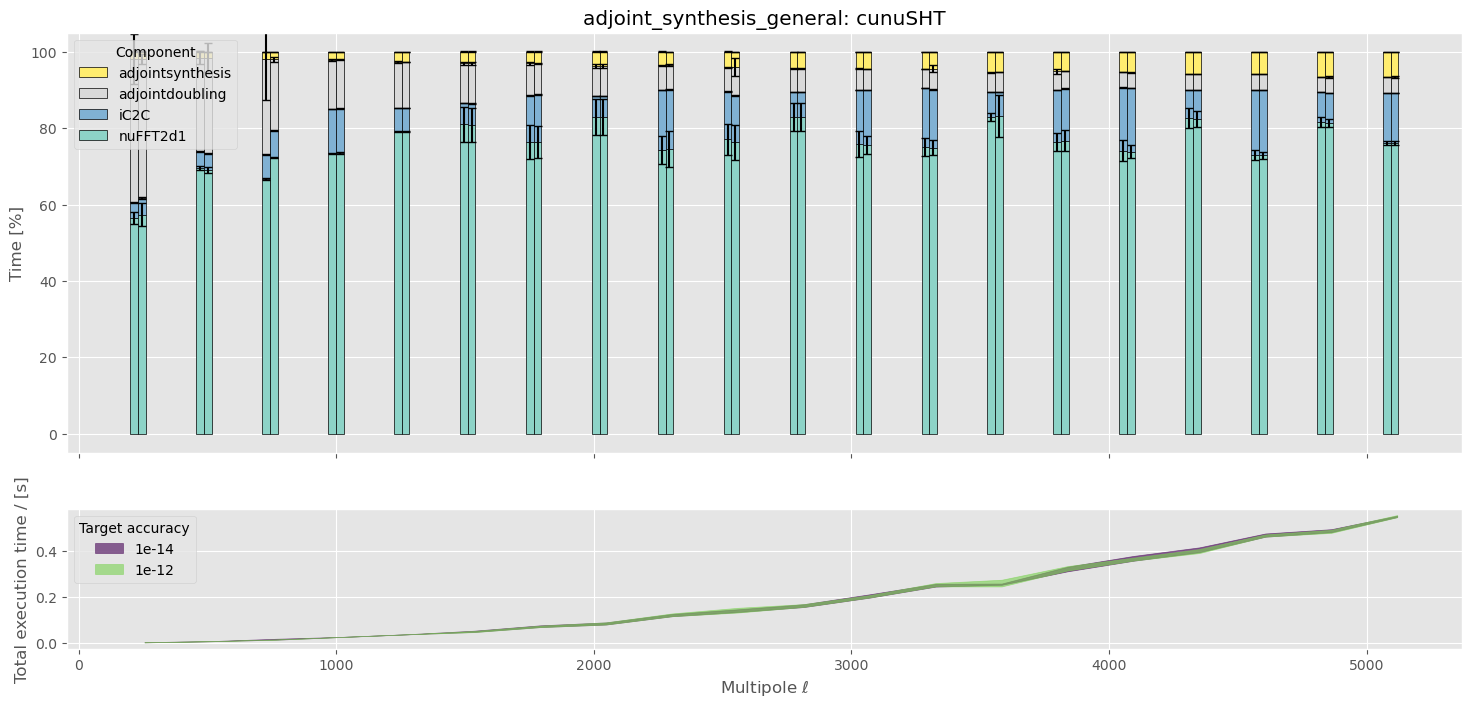

In [8]:
runinfo = ('GPU', 'cufinufft')

colors = plt.cm.Set3(np.linspace(0,1.0,len(keysGPU)))
# For comparison with lenspyx, must sum over all rows
fig, ax = plt.subplots(2,1,figsize=(18,8), sharex=True, sharey=False, gridspec_kw={'height_ratios': [3, 1]})
for ressacci, (ressacc, errs) in enumerate(zip(np.mean(ressGPU,axis=-1), np.std(ressGPU,axis=-1))):
    total = np.sum(ressacc, axis=0)
    bottom = np.zeros(shape=(len(lmaxsGPU)))
    for rowi, (row, err) in enumerate(zip(ressacc[[0,1,2,3]], errs[[0,1,2,3]])):
        ax[0].bar((lmaxsGPU+ressacci*30-len(epsilonsGPU)//2*40), row/total*100, 30, align='center', bottom=bottom, yerr=err/total*100, capsize=3, label=list(keysGPU)[rowi] if ressacci==0 else "", edgecolor='black', color=colors[rowi])
        bottom += row/total*100

ax[0].set_title("adjoint_synthesis_general: cunuSHT".format(runinfo[0], runinfo[1]))
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles[::-1], labels[::-1], title='Component', loc='upper left')
# ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha='center')

# ax[0].set_yticklabels(np.arange(0,110,10))
from matplotlib.ticker import MaxNLocator
# ax[0].yaxis.set_major_locator(MaxNLocator(integer=True))
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
ax[0].set_ylim(-5, 105)
ax[0].yaxis.set_major_locator(MultipleLocator(20))
ax[0].yaxis.set_major_formatter('{x:.0f}')

# ax[0].set_xlabel('Multipole $\ell$')
ax[0].set_ylabel('Time [%]')

resi=0
accuracies = np.array([1/10**(n) for n in np.arange(14,3,-1)])
lmax_acc_time = np.array([[0. for a in range(len(lmaxsGPU))] for n in range(len(epsilonsGPU))]).T
lmax_acc_time_err = np.array([[0. for a in range(len(lmaxsGPU))] for n in range(len(epsilonsGPU))]).T


for ni, n in enumerate(range(lmax_acc_time.shape[-1])):
    lmax_acc_time[:,n] = np.sum(np.mean(ressGPU,axis=-1)[ni], axis=0)
    lmax_acc_time_err[:,n] = np.sum(np.std(ressGPU,axis=-1)[ni], axis=0)
print(lmax_acc_time.shape)


colors = plt.cm.viridis(np.linspace(0,0.8,len(epsilonsGPU)))
for acc_datai, acc_data in enumerate(lmax_acc_time.T):
    ax[1].fill_between(lmaxsGPU, acc_data-lmax_acc_time_err.T[acc_datai], acc_data+lmax_acc_time_err.T[acc_datai], alpha=0.6, color=colors[acc_datai], label=f'{epsilonsGPU[acc_datai]}')
    # ax[1].plot(lmaxsGPU, acc_data, label=f'{epsilonsGPU[acc_datai]}', color=colors[acc_datai], lw=3)
    # ax[1].plot(epsilons, acc_data, label=f'{lmaxs[::-1][acc_datai]}', color=colors[acc_datai], lw=3)
    
# ax[1].legend(title=r'$\ell_{\rm max}$')
ax[1].legend(title='Target accuracy', loc='upper left')

ax[1].set_xlabel('Accuracy') 
ax[1].set_xlabel('Multipole $\ell$')    
ax[1].set_ylabel('Total execution time / [s]')
# ax[1].set_xscale('log')
# ax[1].set_yscale('log')

### Lenspyx

[ 255  511  767 1023 1279 1535 1791 2047 2303 2559 2815 3071 3327 3583
 3839 4095 4351 4607 4863] 19


/tmp/ipykernel_2275150/3738507269.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(["{:.3f}".format(n) for n in [gpu_xlim,gpu_xlim/4*3,gpu_xlim/4*2,gpu_xlim/4*1, 0, cpu_xlim/4, cpu_xlim/4*2, cpu_xlim/4*3, cpu_xlim]])
/tmp/ipykernel_2275150/3738507269.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  axt.set_yticklabels(["{:3.2e}".format(l) for l in lmax2npoints(lmax_intersecs)])


Text(0.25, 0.5, 'GPU')

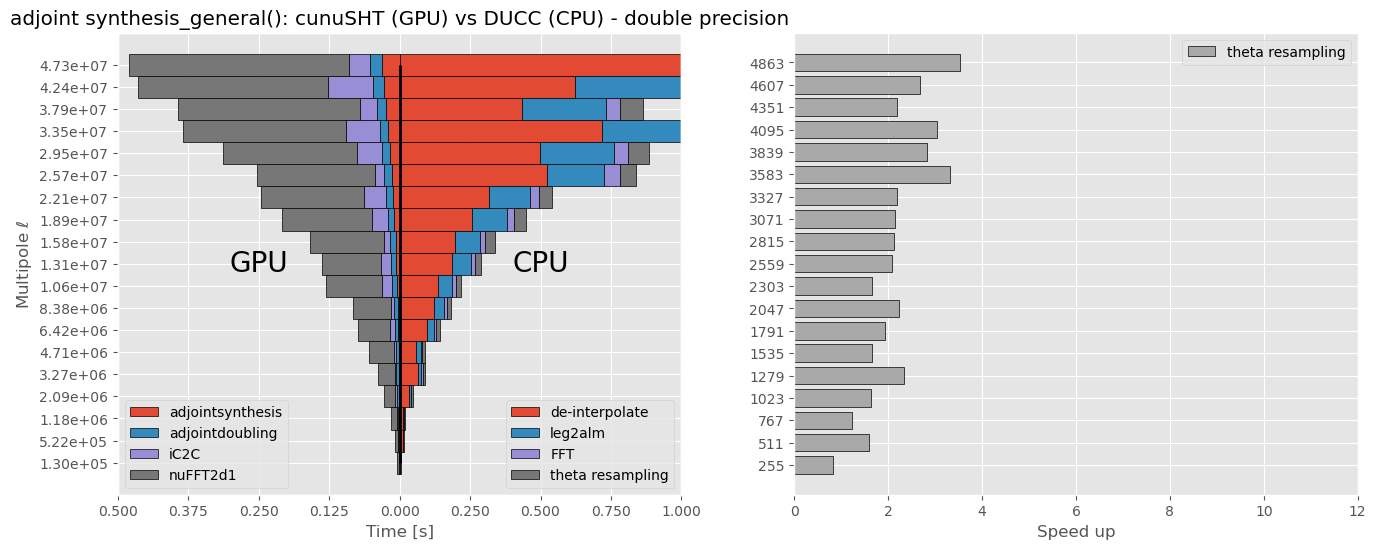

In [47]:
compis = [0,1]
fig, ax = plt.subplots(1,len(runinfos), figsize=(16,6), sharey=False)
lmax_intersecs = np.array(sorted(list(
    set(lmax_ress[compis[0]]).intersection(set(lmax_ress[compis[1]])))))
print(lmax_intersecs, len(lmax_intersecs))

gpu_xlim = 0.5
cpu_xlim = 1
ax[0].set_xticklabels(["{:.3f}".format(n) for n in [gpu_xlim,gpu_xlim/4*3,gpu_xlim/4*2,gpu_xlim/4*1, 0, cpu_xlim/4, cpu_xlim/4*2, cpu_xlim/4*3, cpu_xlim]])

axt = ax[0].twiny()
keys = list(data[1][0].keys())[::-1]
bottom = np.zeros(shape=(len(lmax_intersecs)))
for rowi, row in enumerate(ress[1][::-1]): #[:-1,:]
    mask21 = np.isin(lmax_ress[compis[1]], lmax_ress[compis[0]])
    axt.barh(lmax_intersecs.astype(str), -row[mask21], 1, align='center', left=bottom, label=list(keys)[rowi], edgecolor='black')
    bottom -= row
    axt.set_xlim(-gpu_xlim, gpu_xlim)
    
axt.legend(ncol=1, loc='lower left')
    
bottom = np.zeros(shape=(len(lmax_intersecs)))
keys = data[0][0].keys()
for rowi, row in enumerate(ress[0][::-1]): #[:-1,:]
    mask12 = np.isin(lmax_ress[compis[0]], lmax_ress[compis[1]])
    ax[0].barh(lmax_intersecs.astype(str), row[mask12], 1, align='center', left=bottom, label=list(keys)[::-1][rowi], edgecolor='black')#, color='green')
    bottom += row[mask12]
    ax[0].set_xlim(-cpu_xlim, cpu_xlim)
    
# axt.set_yticks(lmax2npoints(lmax_intersecs))
axt.set_yticklabels(["{:3.2e}".format(l) for l in lmax2npoints(lmax_intersecs)])
        
ax[0].legend(ncol=1, loc='lower right')
axt.vlines(0,0,len(lmax_intersecs[:-1]), color='black', lw=2)
axt.set_title("adjoint synthesis_general(): cunuSHT (GPU) vs DUCC (CPU) - double precision")
ax[0].set_xlabel('Time [s]')
axt.set_ylabel(r'Multipole $\ell$')
axt.set_xticks([])


width = np.diff(lmax_ress[compis[0]])[0]//3

bottom = np.zeros(shape=(len(lmax_intersecs)))
keys = data[0][0].keys()
for rowi, (row1, row2) in enumerate(
    zip(
        [np.sum(ress[compis[0]],axis=0)], [np.sum(ress[compis[1]],axis=0)])):
    mask12 = np.isin(lmax_ress[compis[0]], lmax_ress[compis[1]])
    mask21 = np.isin(lmax_ress[compis[1]], lmax_ress[compis[0]])
    offset = 0 #-width + rowi/len(keys)*2*width
    ax[1].barh((lmax_intersecs+offset), row1[mask12]/row2[mask21], 200, align='center', label=list(keys)[rowi], edgecolor='black', color='darkgrey')
    # bottom += row1[mask12]/row2[mask21]
ax[1].legend()


ax[1].set_yticks(lmax_intersecs)
ax[1].set_yticklabels(["{:d}".format(l) for l in lmax_intersecs])
# ax[1].set_title("{}: {}".format(runinfos[resi][0], runinfos[resi][1]))
ax[1].set_xlabel('Speed up')
ax[0].set_ylabel(r'Multipole $\ell$')


ax[1].set_xlim(0, 12) # 30

ax[0].text(0.75, 0.5, 'CPU', horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes, fontsize=20)
ax[0].text(0.25, 0.5, 'GPU'.format(":\nplanned"), horizontalalignment='center', verticalalignment='center', transform=axt.transAxes, fontsize=20)

# ax[resi].set_ylim(0.0, 1.5)
# handles, labels = ax[1].get_legend_handles_labels()
# ax[1].legend(handles[::-1], labels[::-1], title='Line', loc='upper left')

## gclm2lenmap

In [8]:
popstr_runinfos_CPU = [
    ["CPU_Lenspyx_transformer"],
    ["init"],
    ["gclm2lenmap"],
    ["synthesisgeneral"],
    ["setup"],
    ["plane", "SphereInterpol setup", "borders"],
    ["dlm2pointing", "dlm2pointing - allocation", "dlm2pointing - dlm scaling"],
    ["pointing"],
    ["spin-1 synth"],
    # ["nuFFT2d2", "C2C", "synthesis"],
    # ["alm2leg", "theta resampling", "FFT"],
    # ["nuFFT2d2", "C2C", "doubling", "synthesis"],
    ["rotation", "rotate"],
    ["Transfers ->", "Transfer <-"],
]

planned = "planned"
popstrCPU = flatten_extend(popstr_runinfos_CPU)

runinfo = ('CPU', 'lenspyx')
blacklist_runinfos = []
dirnames = os.path.dirname(cunusht.__file__)[:-8]+'/test/benchmark/timings/{}/{}/'
fns = dirnames.format("CPU_Lenspyx_transformer", "gclm2lenmap") + "lmax{lmax}_epsilon{epsilon:1.0e}_run{run:02d}"

_ = []
print(f"searching for all files with epsilon in " + ",".join([f"{ep:1.0e}" for ep in epsilons])+" and lmax in " + ",".join([f"{lm}" for lm in lmaxs])+"")
for epsilon in epsilons:
    for lmax in lmaxs:
        for run in runs:
            fn = fns.format(backend=runinfo[0], solver=runinfo[1], lmax=lmax, epsilon=epsilon, planned=planned, run=run)
            if not os.path.isfile(fn):
                print(f"couldnt find {fn}")
                blacklist_runinfos.append(lmax)
if len(blacklist_runinfos)>0:
    print(f"Not found: {blacklist_runinfos}")
else:
    print("All files found")
    
print("Loading files")
dataCPU = []
for epsilon in epsilons:
    _ = []
    for lmax in lmaxs:
        if lmax not in blacklist_runinfos:
            mergedict = {}
            for run in runs:
                fn = fns.format(backend=runinfo[0], solver=runinfo[1], lmax=lmax, epsilon=epsilon, planned=planned, run=run)
                with open(fn, "r") as file:
                    newdict = json.load(file)
                    for key in newdict.keys():
                        if key in mergedict:
                            mergedict[key] = mergedict[key] + [newdict[key]]
                        else:
                            mergedict[key] = [newdict[key]]
            _.append(mergedict)
        else:
            print(f"not appending {lmax} to {runinfo}")
    dataCPU.append(_)
    print(len(dataCPU[0]), len(_))
    # print(epsilon, np.mean(dataCPU[-1][-1]['nuFFT2d2']))
    # print(_)
# print(np.mean(dataCPU[0][-1]['nuFFT2d2']), np.mean(dataCPU[1][-1]['nuFFT2d2']))

for epsiloni, epsilon in enumerate(epsilons):
    popstr = popstrCPU
    for popstring in popstr:
        for d in dataCPU[epsiloni]:
            if popstring in d:
                d.pop(popstring)
    # print(epsilon, dataCPU[epsiloni])
          
ressCPU = []
keysCPU = np.array(list(dataCPU[0][0].keys()))[[1,0,2,3]]
for epsiloni, epsilon in enumerate(epsilons):
    data_across_lCPU = {}
    for d in dataCPU[epsiloni]:
        for keyi, key in enumerate(d.keys()):
            if key in data_across_lCPU:
                data_across_lCPU[key].append(d[key])
            else:
                data_across_lCPU[key] = [d[key]]
    _ = np.array([v for k, v in data_across_lCPU.items()])
    ressCPU.append(_)
    # print(epsilon, ressCPU[-1])
# print(ressCPU)
ressCPU = np.array(ressCPU)
print(ressCPU.shape, "epsilon, keys, lmax")

searching for all files with epsilon in 1e-14,1e-12,1e-10,1e-08,1e-06 and lmax in 255,511,767,1023,1279,1535,1791,2047,2303,2559,2815,3071,3327,3583,3839,4095,4351,4607,4863,5119
All files found
Loading files
20 20
20 20
20 20
20 20
20 20
(5, 4, 20, 10) epsilon, keys, lmax


(22, 5)


Text(0, 0.5, 'Total execution time / [s]')

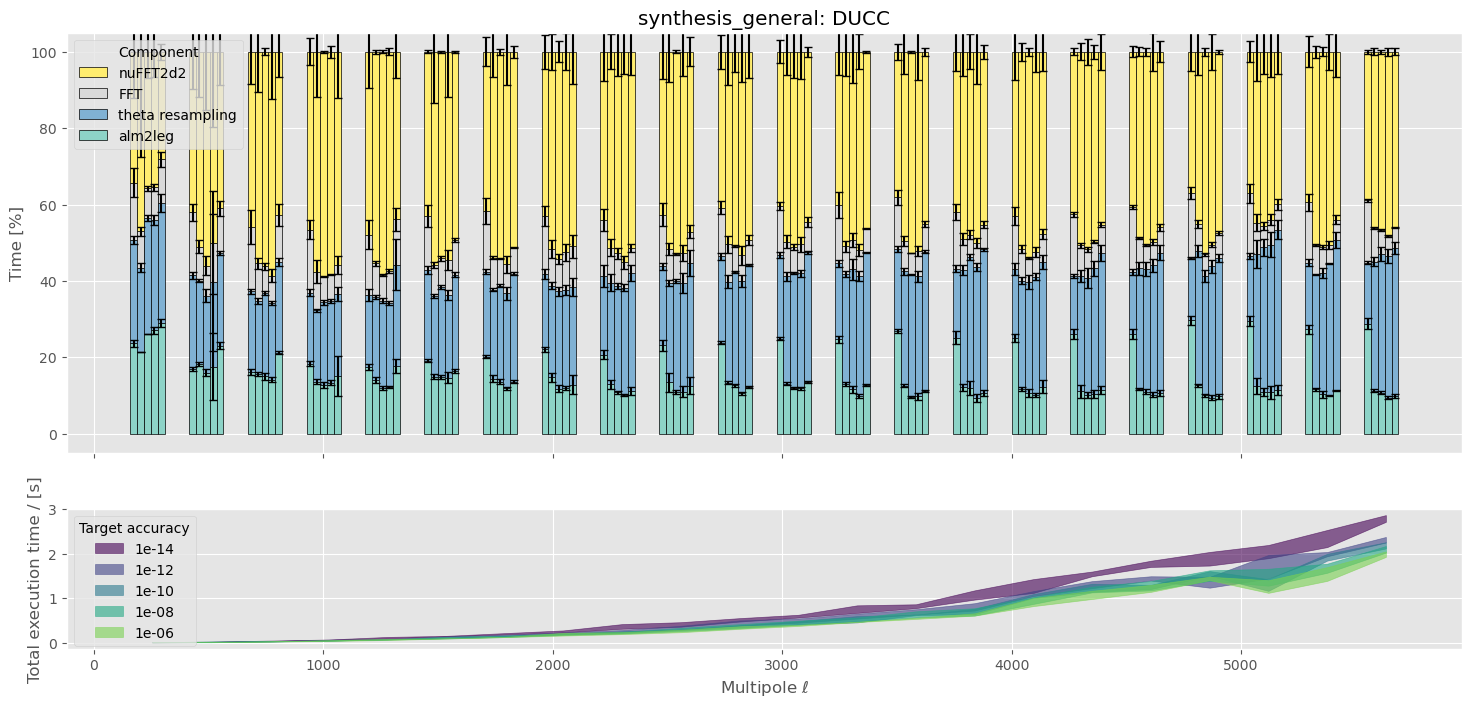

In [83]:
runinfo = ('CPU', 'lenspyx')

colors = plt.cm.Set3(np.linspace(0,1.0,len(keysCPU)))
# For comparison with lenspyx, must sum over all rows
fig, ax = plt.subplots(2,1,figsize=(18,8), sharex=True, sharey=False, gridspec_kw={'height_ratios': [3, 1]})
for ressacci, (ressacc, errs) in enumerate(zip(np.mean(ressCPU,axis=-1), np.std(ressCPU,axis=-1))):
    total = np.sum(ressacc, axis=0)
    bottom = np.zeros(shape=(len(lmaxs)))
    for rowi, (row, err) in enumerate(zip(ressacc[[1,0,2,3]], errs[[1,0,2,3]])):
        ax[0].bar((lmaxs+ressacci*30-len(epsilons)//2*40), row/total*100, 30, align='center', bottom=bottom, yerr=err/total*100, capsize=3, label=list(keysCPU)[rowi] if ressacci==0 else "", edgecolor='black', color=colors[rowi])
        bottom += row/total*100

ax[0].set_title("synthesis_general: DUCC".format(runinfo[0], runinfo[1]))
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles[::-1], labels[::-1], title='Component', loc='upper left')
# ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha='center')

# ax[0].set_yticklabels(np.arange(0,110,10))
from matplotlib.ticker import MaxNLocator
# ax[0].yaxis.set_major_locator(MaxNLocator(integer=True))
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
ax[0].set_ylim(-5, 105)
ax[0].yaxis.set_major_locator(MultipleLocator(20))
ax[0].yaxis.set_major_formatter('{x:.0f}')

# ax[0].set_xlabel('Multipole $\ell$')
ax[0].set_ylabel('Time [%]')

resi=0
accuracies = np.array([1/10**(n) for n in np.arange(14,3,-1)])
lmax_acc_time = np.array([[0. for a in range(len(lmaxs))] for n in range(len(epsilons))]).T
lmax_acc_time_err = np.array([[0. for a in range(len(lmaxs))] for n in range(len(epsilons))]).T


for ni, n in enumerate(range(lmax_acc_time.shape[-1])):
    lmax_acc_time[:,n] = np.sum(np.mean(ressCPU,axis=-1)[ni], axis=0)
    lmax_acc_time_err[:,n] = np.sum(np.std(ressCPU,axis=-1)[ni], axis=0)
    # print(np.sum(np.mean(ressCPU,axis=-1)[ni], axis=0))
# lmax_acc_time[:,-7] = np.sum(ress[resi], axis=0)*1.1
print(lmax_acc_time.shape)
# ax[1].set_xticklabels(accuracies, rotation=40, ha='center')

colors = plt.cm.viridis(np.linspace(0,0.8,len(epsilons)))
for acc_datai, acc_data in enumerate(lmax_acc_time.T):
    ax[1].fill_between(lmaxs, acc_data-lmax_acc_time_err.T[acc_datai], acc_data+lmax_acc_time_err.T[acc_datai], alpha=0.6, color=colors[acc_datai], label=f'{epsilons[acc_datai]}')
    # ax[1].plot(epsilons, acc_data, label=f'{lmaxs[::-1][acc_datai]}', color=colors[acc_datai], lw=3)
    
# ax[1].legend(title=r'$\ell_{\rm max}$')
ax[1].legend(title='Target accuracy', loc='upper left')

ax[1].set_xlabel('Accuracy') 
ax[1].set_xlabel('Multipole $\ell$')    
ax[1].set_ylabel('Total execution time / [s]')
# ax[1].set_xscale('log')
# ax[1].set_yscale('log')

#### GPU

In [16]:
lmaxsGPU = np.array([256*n-1 for n in np.arange(1,21)])

popstr_runinfos_GPU = [
    ["GPU_cufinufft_transformer"],
    ["init - setup", "init - deflectionlib", "init - SHTlib", "init - allocation", "init - weights", "nuFFT and C2C - plan", "init"],
    ["gclm2lenmap"],
    ["synthesisgeneral"],
    ["setup"],
    ["nuFFT - init", "nuFFT - plan"],
    # ['nuFFT - exec', 'nuFFT - set points']
    ["dlm2pointing"],
    ["pointing"],
    ["spin-1 synth"],
    ["ascontiguousarray"],
    # ["nuFFT2d2", "C2C", "synthesis"],
    # ["nuFFT2d2", "C2C", "doubling", "synthesis"],
    # ["doubling"],
    ["rotation", "rotate"],
    ["Transfer ->", "Transfer <-"],
]

runinfo = ('GPU', 'cufinufft')
blacklist_runinfos = []
planned = "planned"
popstrGPU = flatten_extend(popstr_runinfos_GPU)
dirnames = os.path.dirname(cunusht.__file__)[:-8]+'/test/benchmark/timings/{}/{}/'
fns = dirnames.format("GPU_cufinufft_transformer", "gclm2lenmap") + "lmax{lmax}_epsilon{epsilon:1.0e}_run{run:02d}"
dataGPU = []
epsilonsGPU = [1e-14, 1e-12, 1e-10, 1e-08, 1e-06]

_ = []
print(f"searching for all files with epsilon in " + ",".join([f"{ep:1.0e}" for ep in epsilons])+" and lmax in " + ",".join([f"{lm}" for lm in lmaxs])+"")
for epsilon in epsilonsGPU:
    for lmax in lmaxsGPU:
        for run in runs:
            fn = fns.format(backend=runinfo[0], solver=runinfo[1], lmax=lmax, epsilon=epsilon, planned=planned, run=run)
            if not os.path.isfile(fn):
                print(f"couldnt find {fn}")
                blacklist_runinfos.append(lmax)
if len(blacklist_runinfos)>0:
    print(f"Not found: {blacklist_runinfos}")
else:
    print("All files found")

print("Loading files")
dataGPU = []
for epsilon in epsilonsGPU:
    _ = []
    for lmax in lmaxsGPU:
        if lmax not in blacklist_runinfos:
            mergedict = {}
            for run in runs:
                fn = fns.format(backend=runinfo[0], solver=runinfo[1], lmax=lmax, epsilon=epsilon, planned=planned, run=run)
                with open(fn, "r") as file:
                    newdict = json.load(file)
                    for key in newdict.keys():
                        if key in mergedict:
                            mergedict[key] = mergedict[key] + [newdict[key]]
                        else:
                            mergedict[key] = [newdict[key]]
            _.append(mergedict)
        else:
            print(f"not appending {lmax} to {runinfo}")
    dataGPU.append(_)
    print(len(dataGPU[0]), len(_))
    # print(epsilon, np.mean(dataCPU[-1][-1]['nuFFT2d2']))
    # print(_)
# print(np.mean(dataCPU[0][-1]['nuFFT2d2']), np.mean(dataCPU[1][-1]['nuFFT2d2']))

for epsiloni, epsilon in enumerate(epsilonsGPU):
    popstr = popstrGPU
    for popstring in popstr:
        for d in dataGPU[epsiloni]:
            if popstring in d:
                d.pop(popstring)
    # print(epsilon, dataCPU[epsiloni])
     
ressGPU = []
keysGPU = np.array(list(dataGPU[0][0].keys()))#[[1,0,2,3]]
for epsiloni, epsilon in enumerate(epsilonsGPU):
    data_across_lGPU = {}
    for d in dataGPU[epsiloni]:
        for keyi, key in enumerate(d.keys()):
            if key in data_across_lGPU:
                data_across_lGPU[key].append(d[key])
            else:
                data_across_lGPU[key] = [d[key]]
    _ = np.array([v for k, v in data_across_lGPU.items()])
    ressGPU.append(_)
    # print(epsilon, ressCPU[-1])
# print(ressCPU)
ressGPU = np.array(ressGPU)
print(ressGPU.shape, "epsilon, keys, lmax")

searching for all files with epsilon in 1e-14,1e-12,1e-10,1e-08,1e-06 and lmax in 255,511,767,1023,1279,1535,1791,2047,2303,2559,2815,3071,3327,3583,3839,4095,4351,4607,4863,5119
All files found
Loading files
20 20
20 20
20 20
20 20
20 20
(5, 4, 20, 10) epsilon, keys, lmax


(20, 5)


Text(0, 0.5, 'Total execution time / [s]')

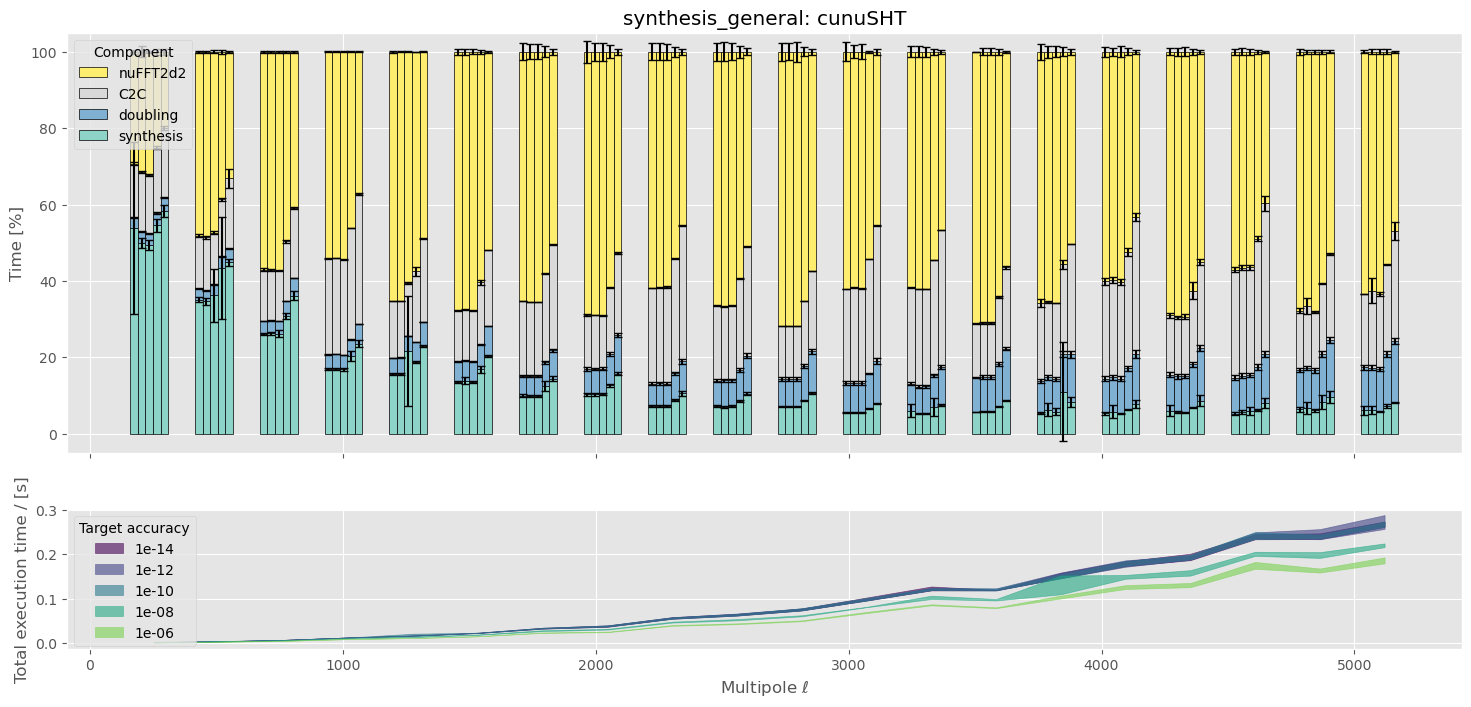

In [79]:
runinfo = ('GPU', 'cufinufft')

colors = plt.cm.Set3(np.linspace(0,1.0,len(keysGPU)))
# For comparison with lenspyx, must sum over all rows
fig, ax = plt.subplots(2,1,figsize=(18,8), sharex=True, sharey=False, gridspec_kw={'height_ratios': [3, 1]})
for ressacci, (ressacc, errs) in enumerate(zip(np.mean(ressGPU,axis=-1), np.std(ressGPU,axis=-1))):
    total = np.sum(ressacc, axis=0)
    bottom = np.zeros(shape=(len(lmaxsGPU)))
    for rowi, (row, err) in enumerate(zip(ressacc[[1,0,2,3]], errs[[1,0,2,3]])):
        ax[0].bar((lmaxsGPU+ressacci*30-len(epsilonsGPU)//2*40), row/total*100, 30, align='center', bottom=bottom, yerr=err/total*100, capsize=3, label=list(keysGPU)[rowi] if ressacci==0 else "", edgecolor='black', color=colors[rowi])
        bottom += row/total*100

ax[0].set_title("synthesis_general: cunuSHT".format(runinfo[0], runinfo[1]))
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles[::-1], labels[::-1], title='Component', loc='upper left')
# ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha='center')

# ax[0].set_yticklabels(np.arange(0,110,10))
from matplotlib.ticker import MaxNLocator
# ax[0].yaxis.set_major_locator(MaxNLocator(integer=True))
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
ax[0].set_ylim(-5, 105)
ax[0].yaxis.set_major_locator(MultipleLocator(20))
ax[0].yaxis.set_major_formatter('{x:.0f}')

# ax[0].set_xlabel('Multipole $\ell$')
ax[0].set_ylabel('Time [%]')

resi=0
accuracies = np.array([1/10**(n) for n in np.arange(14,3,-1)])
lmax_acc_time = np.array([[0. for a in range(len(lmaxsGPU))] for n in range(len(epsilonsGPU))]).T
lmax_acc_time_err = np.array([[0. for a in range(len(lmaxsGPU))] for n in range(len(epsilonsGPU))]).T


for ni, n in enumerate(range(lmax_acc_time.shape[-1])):
    lmax_acc_time[:,n] = np.sum(np.mean(ressGPU,axis=-1)[ni], axis=0)
    lmax_acc_time_err[:,n] = np.sum(np.std(ressGPU,axis=-1)[ni], axis=0)
print(lmax_acc_time.shape)


colors = plt.cm.viridis(np.linspace(0,0.8,len(epsilonsGPU)))
for acc_datai, acc_data in enumerate(lmax_acc_time.T):
    ax[1].fill_between(lmaxsGPU, acc_data-lmax_acc_time_err.T[acc_datai], acc_data+lmax_acc_time_err.T[acc_datai], alpha=0.6, color=colors[acc_datai], label=f'{epsilonsGPU[acc_datai]}')
    # ax[1].plot(lmaxsGPU, acc_data, label=f'{epsilonsGPU[acc_datai]}', color=colors[acc_datai], lw=3)
    # ax[1].plot(epsilons, acc_data, label=f'{lmaxs[::-1][acc_datai]}', color=colors[acc_datai], lw=3)
    
# ax[1].legend(title=r'$\ell_{\rm max}$')
ax[1].legend(title='Target accuracy', loc='upper left')

ax[1].set_xlabel('Accuracy') 
ax[1].set_xlabel('Multipole $\ell$')    
ax[1].set_ylabel('Total execution time / [s]')
# ax[1].set_xscale('log')
# ax[1].set_yscale('log')

### Transfer / pointing (change popstring)

In [46]:
lmaxsGPU = np.array([256*n-1 for n in np.arange(1,21)])

popstr_runinfos_GPU = [
    ["GPU_cufinufft_transformer"],
    ["init - setup", "init - deflectionlib", "init - SHTlib", "init - allocation", "init - weights", "nuFFT and C2C - plan", "init"],
    ["gclm2lenmap"],
    ["synthesisgeneral"],
    ["setup"],
    ["nuFFT - init", "nuFFT - plan"],
    # ['nuFFT - exec', 'nuFFT - set points']
    # ["dlm2pointing"],
    ["pointing"],
    ["spin-1 synth"],
    ["ascontiguousarray"],
    ["nuFFT2d2", "C2C", "synthesis"],
    ["nuFFT2d2", "C2C", "doubling", "synthesis"],
    # ["doubling"],
    ["rotation", "rotate"],
    ["Transfer ->", "Transfer <-"],
]

runinfo = ('GPU', 'cufinufft')
blacklist_runinfos = []
planned = "planned"
popstrGPU = flatten_extend(popstr_runinfos_GPU)
dirnames = os.path.dirname(cunusht.__file__)[:-8]+'/test/benchmark/timings/{}/{}/'
fns = dirnames.format("GPU_cufinufft_transformer", "gclm2lenmap") + "lmax{lmax}_epsilon{epsilon:1.0e}_run{run:02d}"
dataGPU = []
epsilonsGPU = [1e-14, 1e-12, 1e-10, 1e-08, 1e-06]

_ = []
print(f"searching for all files with epsilon in " + ",".join([f"{ep:1.0e}" for ep in epsilons])+" and lmax in " + ",".join([f"{lm}" for lm in lmaxs])+"")
for epsilon in epsilonsGPU:
    for lmax in lmaxsGPU:
        for run in runs:
            fn = fns.format(backend=runinfo[0], solver=runinfo[1], lmax=lmax, epsilon=epsilon, planned=planned, run=run)
            if not os.path.isfile(fn):
                print(f"couldnt find {fn}")
                blacklist_runinfos.append(lmax)
if len(blacklist_runinfos)>0:
    print(f"Not found: {blacklist_runinfos}")
else:
    print("All files found")

print("Loading files")
dataGPU = []
for epsilon in epsilonsGPU:
    _ = []
    for lmax in lmaxsGPU:
        if lmax not in blacklist_runinfos:
            mergedict = {}
            for run in runs:
                fn = fns.format(backend=runinfo[0], solver=runinfo[1], lmax=lmax, epsilon=epsilon, planned=planned, run=run)
                with open(fn, "r") as file:
                    newdict = json.load(file)
                    for key in newdict.keys():
                        if key in mergedict:
                            mergedict[key] = mergedict[key] + [newdict[key]]
                        else:
                            mergedict[key] = [newdict[key]]
            _.append(mergedict)
        else:
            print(f"not appending {lmax} to {runinfo}")
    dataGPU.append(_)
    print(len(dataGPU[0]), len(_))

for epsiloni, epsilon in enumerate(epsilonsGPU):
    popstr = popstrGPU
    for popstring in popstr:
        for d in dataGPU[epsiloni]:
            if popstring in d:
                d.pop(popstring)
    # print(epsilon, dataCPU[epsiloni])
     
ressGPU = []
keysGPU = np.array(list(dataGPU[0][0].keys()))#[[1,0,2,3]]
for epsiloni, epsilon in enumerate(epsilonsGPU):
    data_across_lGPU = {}
    for d in dataGPU[epsiloni]:
        for keyi, key in enumerate(d.keys()):
            if key in data_across_lGPU:
                data_across_lGPU[key].append(d[key])
            else:
                data_across_lGPU[key] = [d[key]]
    _ = np.array([v for k, v in data_across_lGPU.items()])
    ressGPU.append(_)
ressGPU = np.array(ressGPU)
print(ressGPU.shape, "epsilon, keys, lmax")

searching for all files with epsilon in 1e-14,1e-12,1e-10,1e-08,1e-06 and lmax in 255,511,767,1023,1279,1535,1791,2047,2303,2559,2815,3071,3327,3583,3839,4095,4351,4607,4863,5119
All files found
Loading files
20 20
20 20
20 20
20 20
20 20
(5, 1, 20, 10) epsilon, keys, lmax


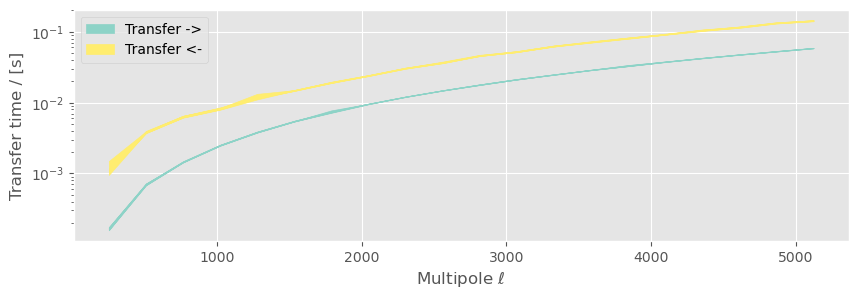

In [70]:
runinfo = ('GPU', 'cufinufft')
colors = plt.cm.Set3(np.linspace(0,1.0,len(keysGPU)))
fig, ax = plt.subplots(1,1,figsize=(10,3))

for ressacci, (ressacc, errs) in enumerate(zip(np.mean(ressGPU,axis=(-1)), np.std(ressGPU,axis=(-1)))):
    for rowi, (row, err) in enumerate(zip(ressacc, errs)):
        ax.fill_between(lmaxsGPU, row-err, row+err, label=list(keysGPU)[rowi] if ressacci==0 else "", color=colors[rowi], ls='-')
        # ax.plot(lmaxsGPU, row, lw=2, color='black')
ax.legend(title=None, loc='upper left')
ax.set_xlabel('Multipole $\ell$')    
ax.set_ylabel('Transfer time / [s]')
# ax[1].set_xscale('log')
ax.set_yscale('log')

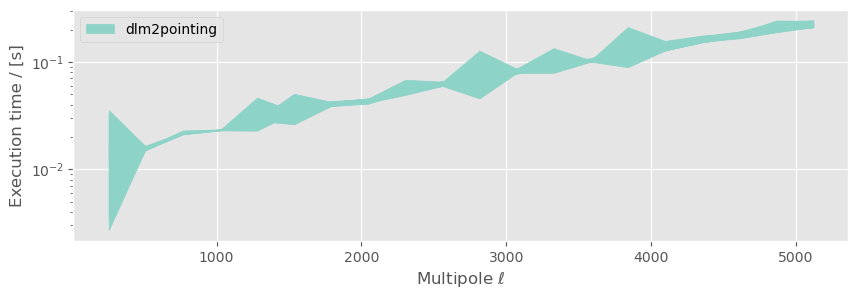

In [47]:
runinfo = ('GPU', 'cufinufft')
colors = plt.cm.Set3(np.linspace(0,1.0,len(keysGPU)))
fig, ax = plt.subplots(1,1,figsize=(10,3))

for ressacci, (ressacc, errs) in enumerate(zip(np.mean(ressGPU,axis=(-1)), np.std(ressGPU,axis=(-1)))):
    for rowi, (row, err) in enumerate(zip(ressacc, errs)):
        ax.fill_between(lmaxsGPU, row-err, row+err, label=list(keysGPU)[rowi] if ressacci==0 else "", color=colors[rowi], ls='-')
        # ax.plot(lmaxsGPU, row, lw=2, color='black')
ax.legend(title=None, loc='upper left')
ax.set_xlabel('Multipole $\ell$')    
ax.set_ylabel('Execution time / [s]')
# ax[1].set_xscale('log')
ax.set_yscale('log')

Text(0, 0.5, 'Speed up factor')

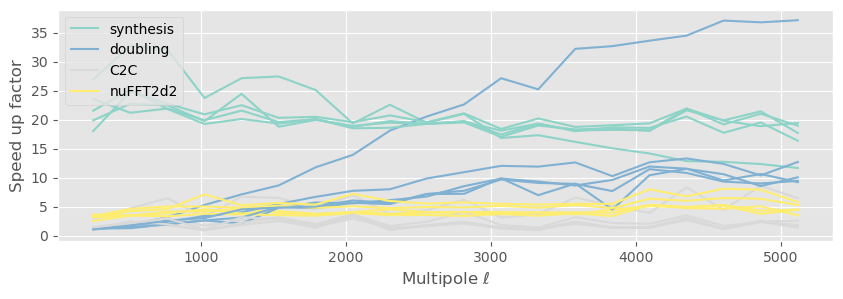

In [20]:
runinfo = ('GPU', 'cufinufft')
colors = plt.cm.Set3(np.linspace(0,1.0,len(keysGPU)))
fig, ax = plt.subplots(1,1,figsize=(10,3))

for ressacci, (ressaccCPU, ressaccGPU) in enumerate(zip(np.mean(ressCPU,axis=(-1)), np.mean(ressGPU,axis=(-1)))):
    for rowi, (rowC, rowG) in enumerate(zip(ressaccCPU, ressaccGPU)):
        ax.plot(lmaxsGPU, rowC/rowG, label=list(keysGPU)[rowi] if ressacci==0 else "", color=colors[rowi], ls='-')
        # ax.plot(lmaxsGPU, row, lw=2, color='black')
ax.legend(title=None, loc='upper left')
ax.set_xlabel('Multipole $\ell$')    
ax.set_ylabel('Speed up factor')
# ax[1].set_xscale('log')
# ax.set_yscale('log')

Text(0, 0.5, 'Speed up factor')

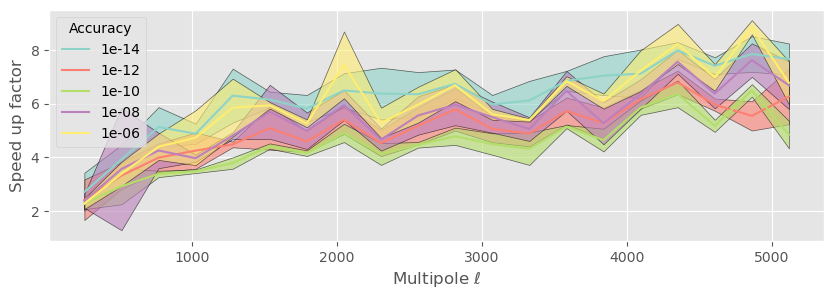

In [41]:
runinfo = ('GPU', 'cufinufft')
colors = plt.cm.Set3(np.linspace(0,1.0,len(epsilons)))
fig, ax = plt.subplots(1,1,figsize=(10,3))

for ressacci, (ressaccCPU, ressaccGPU, errsCPU, errsGPU) in enumerate(zip(np.mean(ressCPU,axis=(-1)), np.mean(ressGPU,axis=(-1)), np.std(ressCPU,axis=(-1)), np.std(ressGPU,axis=(-1)))):
    totalC = np.sum(ressaccCPU, axis=0)
    totalG = np.sum(ressaccGPU, axis=0)
    
    totalerrC = np.sum(errsCPU, axis=0)
    totalerrG = np.sum(errsGPU, axis=0)
    
    # ax.plot(lmaxsGPU, totalC/totalG, label=list(epsilons)[ressacci], color=colors[ressacci], ls='-')
    ax.fill_between(lmaxsGPU, (totalC-totalerrC-totalerrG)/totalG, (totalC+totalerrC+totalerrG)/totalG, color=colors[ressacci], ls='-', alpha=0.6, edgecolor='black')
    ax.plot(lmaxsGPU, totalC/totalG, color=colors[ressacci], ls='-', label=epsilons[ressacci])
ax.legend(title='Accuracy', loc='upper left')
ax.set_xlabel('Multipole $\ell$')    
ax.set_ylabel('Speed up factor')
# ax[1].set_xscale('log')
# ax.set_yscale('log')

### Old

/tmp/ipykernel_456482/3575544538.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha='center')
/tmp/ipykernel_456482/3575544538.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha='center')


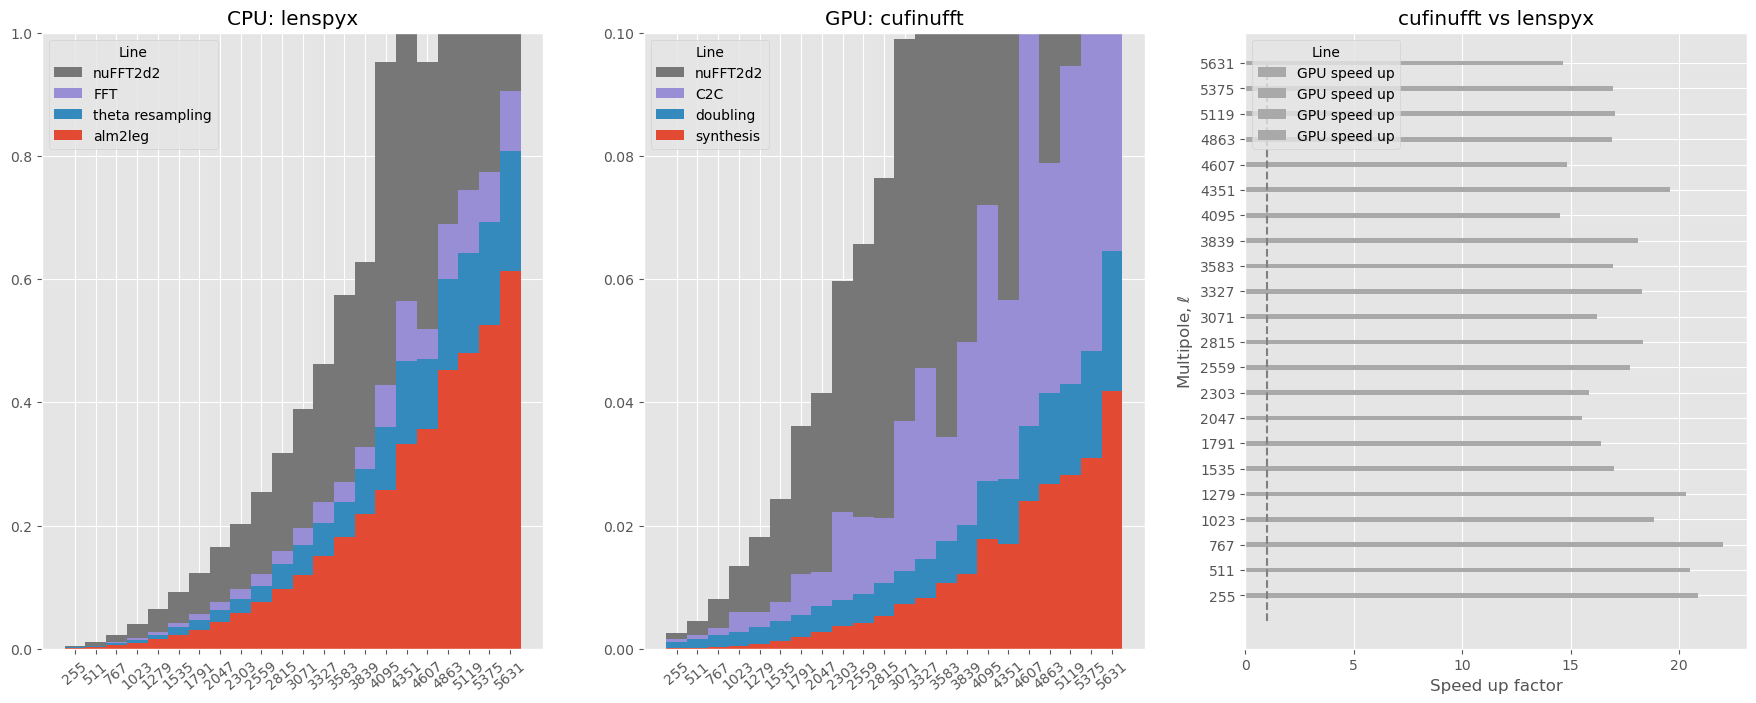

In [113]:
# For comparison with lenspyx, must sum over all rows
fig, ax = plt.subplots(1,len(runinfos)+1,figsize=(22,8), sharey=False)
for resi, res in enumerate(ress):
    bottom = np.zeros(shape=(len(lmax_ress[resi])))
    keys = data[resi][0].keys()
    for rowi, row in enumerate(res): #[:-1,:]
        # if rowi == 0:
            # ax[0].bar(lmaxs.astype(str), [0,0], 1, align='center', bottom=bottom, label='_')
        ax[resi].bar(lmax_ress[resi].astype(str), row, 1, align='center', bottom=bottom, label=list(keys)[rowi])
        bottom += row
    ax[resi].legend()
    ax[resi].set_title("{}: {}".format(runinfos[resi][0], runinfos[resi][1]))
    
    handles, labels = ax[resi].get_legend_handles_labels()
    ax[resi].legend(handles[::-1], labels[::-1], title='Line', loc='upper left')
ax[0].set_ylim(0.0, 1.0)
ax[1].set_ylim(0.0, .1)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha='center')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha='center')

compis = [0,1]
lmax_unions = []
width = np.diff(lmax_ress[compis[0]])[0]//4
lmax_intersecs = np.array(sorted(list(
    set(lmax_ress[compis[0]]).intersection(set(lmax_ress[compis[1]])))))

bottom = np.zeros(shape=(len(lmax_intersecs)))
keys = data[0][0].keys()
for rowi, (row1, row2) in enumerate(
    zip(
        ress[compis[0]], ress[compis[1]])):
    mask12 = np.isin(lmax_ress[compis[0]], lmax_ress[compis[1]])
    mask21 = np.isin(lmax_ress[compis[1]], lmax_ress[compis[0]])
    offset = -width + rowi/len(keys)*2*width
    offset = 0
    ax[2].barh((lmax_intersecs+offset), row1[mask12]/row2[mask21], 3*width/len(keys), align='center', label="GPU speed up", color='darkgrey')
    # bottom += row1[mask12]/row2[mask21]
ax[2].vlines(1,0,np.max(lmax_intersecs), color='grey', ls='--')
ax[2].legend()
ax[2].set_ylabel(r"Multipole, $\ell$")
ax[2].set_xlabel("Speed up factor")
ax[2].set_title("{} vs {}".format(runinfos[1][1], runinfos[0][1]))
ax[2].set_yticks(lmax_intersecs)
ax[2].set_yticklabels(lmax_intersecs)
# ax[resi].set_ylim(0.0, 1.5)
handles, labels = ax[2].get_legend_handles_labels()
ax[2].legend(handles[::-1], labels[::-1], title='Line', loc='upper left')

[ 255  511  767 1023 1279 1535 1791 2047 2303 2559 2815 3071 3327 3583
 3839 4095 4351 4607 4863 5119 5375 5631] 22


/tmp/ipykernel_810472/2528131174.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(["{:.3f}".format(n) for n in [gpu_xlim,gpu_xlim/4*3,gpu_xlim/4*2,gpu_xlim/4*1, 0, cpu_xlim/4, cpu_xlim/4*2, cpu_xlim/4*3, cpu_xlim]])
/tmp/ipykernel_810472/2528131174.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  axt.set_yticklabels(["{:3.2e}".format(l) for l in lmax2npoints(lmax_intersecs)])


Text(0.25, 0.5, 'GPU')

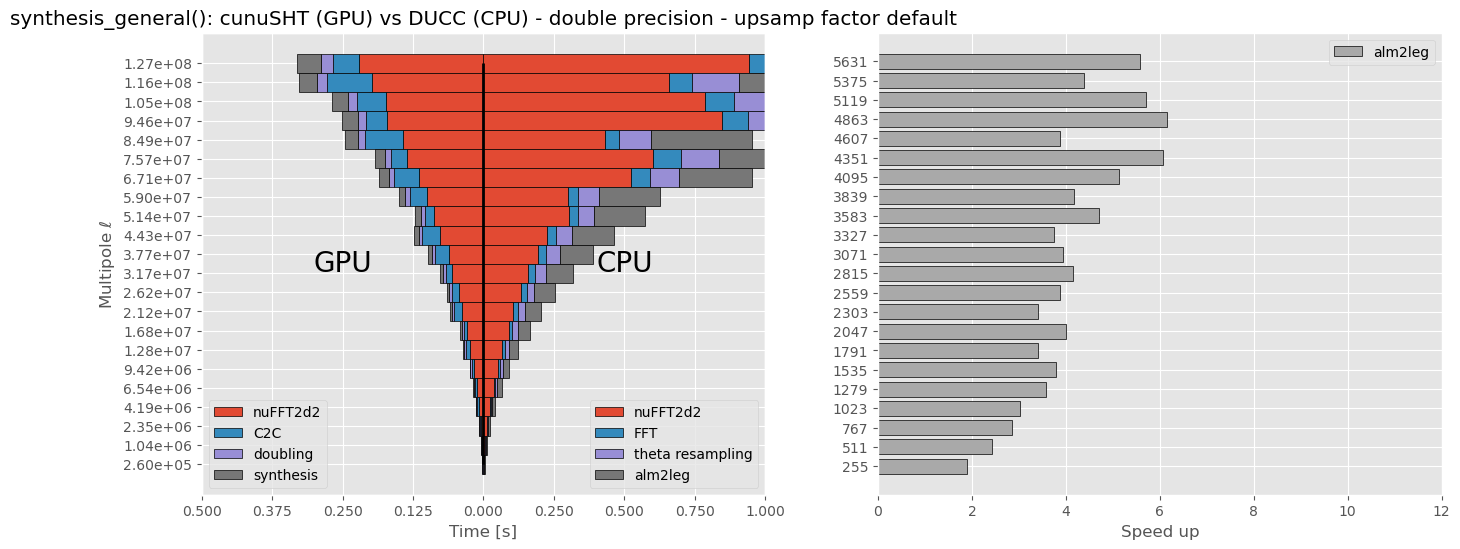

In [10]:
compis = [0,1]
fig, ax = plt.subplots(1,len(runinfos), figsize=(16,6), sharey=False)
lmax_intersecs = np.array(sorted(list(
    set(lmax_ress[compis[0]]).intersection(set(lmax_ress[compis[1]])))))
print(lmax_intersecs, len(lmax_intersecs))

gpu_xlim = 0.5
cpu_xlim = 1
ax[0].set_xticklabels(["{:.3f}".format(n) for n in [gpu_xlim,gpu_xlim/4*3,gpu_xlim/4*2,gpu_xlim/4*1, 0, cpu_xlim/4, cpu_xlim/4*2, cpu_xlim/4*3, cpu_xlim]])

axt = ax[0].twiny()
keys = list(data[1][0].keys())[::-1]
bottom = np.zeros(shape=(len(lmax_intersecs)))
for rowi, row in enumerate(ress[1][::-1]): #[:-1,:]
    mask21 = np.isin(lmax_ress[compis[1]], lmax_ress[compis[0]])
    axt.barh(lmax_intersecs.astype(str), -row[mask21], 1, align='center', left=bottom, label=list(keys)[rowi], edgecolor='black')
    bottom -= row
    axt.set_xlim(-gpu_xlim, gpu_xlim)
    
axt.legend(ncol=1, loc='lower left')
    
bottom = np.zeros(shape=(len(lmax_intersecs)))
keys = data[0][0].keys()
for rowi, row in enumerate(ress[0][::-1]): #[:-1,:]
    mask12 = np.isin(lmax_ress[compis[0]], lmax_ress[compis[1]])
    ax[0].barh(lmax_intersecs.astype(str), row[mask12], 1, align='center', left=bottom, label=list(keys)[::-1][rowi], edgecolor='black')#, color='green')
    bottom += row[mask12]
    ax[0].set_xlim(-cpu_xlim, cpu_xlim)
    
# axt.set_yticks(lmax2npoints(lmax_intersecs))
axt.set_yticklabels(["{:3.2e}".format(l) for l in lmax2npoints(lmax_intersecs)])
        
ax[0].legend(ncol=1, loc='lower right')
axt.vlines(0,0,len(lmax_intersecs[:-1]), color='black', lw=2)
axt.set_title("synthesis_general(): cunuSHT (GPU) vs DUCC (CPU) - double precision - upsamp factor default")
ax[0].set_xlabel('Time [s]')
axt.set_ylabel(r'Multipole $\ell$')
axt.set_xticks([])


width = np.diff(lmax_ress[compis[0]])[0]//3

bottom = np.zeros(shape=(len(lmax_intersecs)))
keys = data[0][0].keys()
for rowi, (row1, row2) in enumerate(
    zip(
        [np.sum(ress[compis[0]],axis=0)], [np.sum(ress[compis[1]],axis=0)])):
    mask12 = np.isin(lmax_ress[compis[0]], lmax_ress[compis[1]])
    mask21 = np.isin(lmax_ress[compis[1]], lmax_ress[compis[0]])
    offset = 0 #-width + rowi/len(keys)*2*width
    ax[1].barh((lmax_intersecs+offset), row1[mask12]/row2[mask21], 200, align='center', label=list(keys)[rowi], edgecolor='black', color='darkgrey')
    # bottom += row1[mask12]/row2[mask21]
ax[1].legend()


ax[1].set_yticks(lmax_intersecs)
ax[1].set_yticklabels(["{:d}".format(l) for l in lmax_intersecs])
# ax[1].set_title("{}: {}".format(runinfos[resi][0], runinfos[resi][1]))
ax[1].set_xlabel('Speed up')
ax[0].set_ylabel(r'Multipole $\ell$')


ax[1].set_xlim(0, 12) # 30

ax[0].text(0.75, 0.5, 'CPU', horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes, fontsize=20)
ax[0].text(0.25, 0.5, 'GPU'.format(":\nplanned"), horizontalalignment='center', verticalalignment='center', transform=axt.transAxes, fontsize=20)

# ax[resi].set_ylim(0.0, 1.5)
# handles, labels = ax[1].get_legend_handles_labels()
# ax[1].legend(handles[::-1], labels[::-1], title='Line', loc='upper left')

In [18]:
tot_Gbyte = (5e7+2*5e7+1e8+2*1e4*1e4)*8/1e9
tot_Gbyte

0.000000001702128

1.702128e-09

### Lenspyx

/tmp/ipykernel_993665/750189834.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha='center')
/tmp/ipykernel_993665/750189834.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha='center')


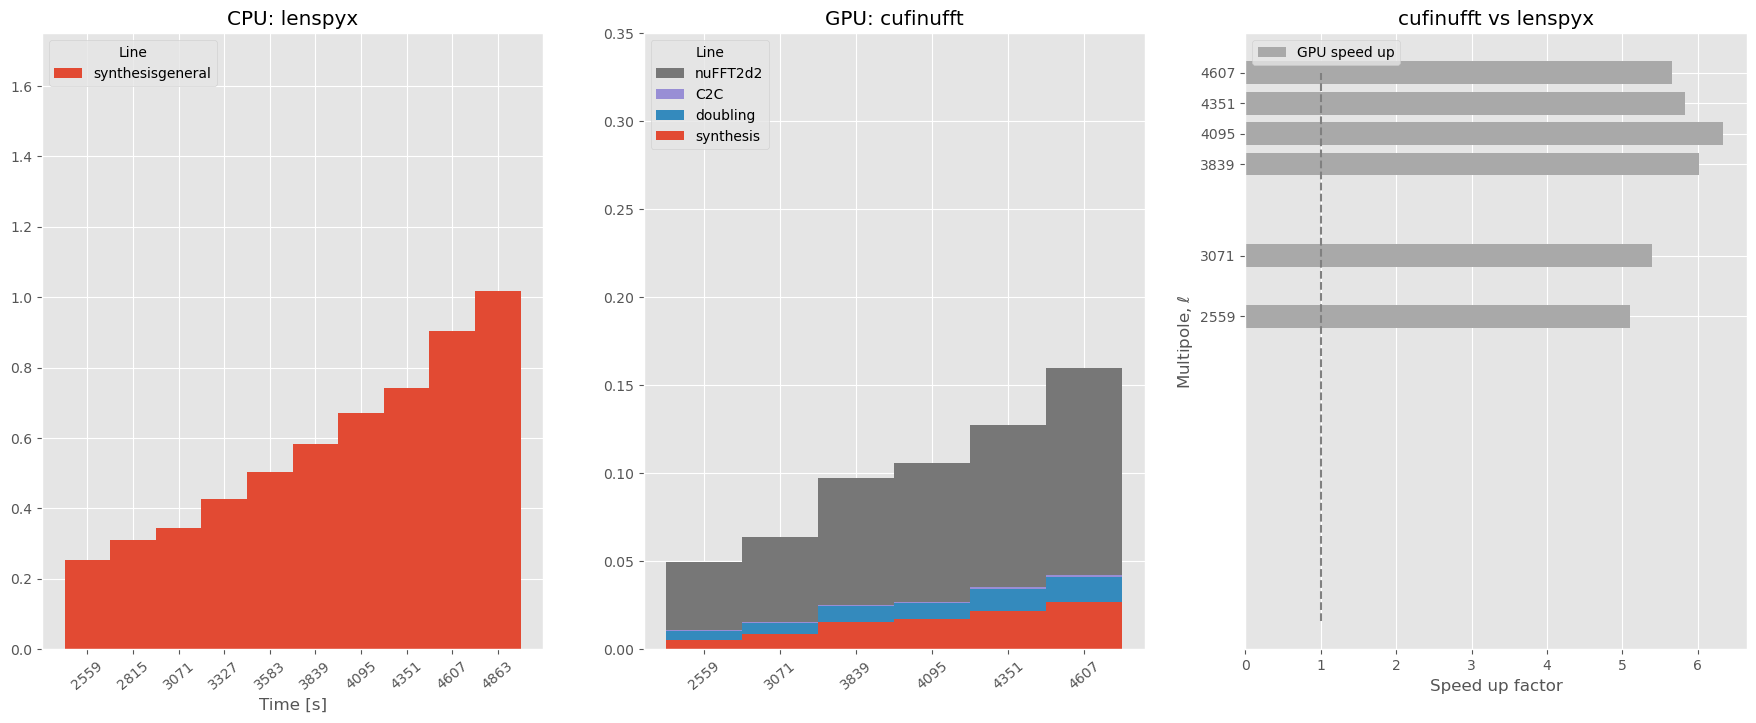

In [25]:
fig, ax = plt.subplots(1,len(runinfos)+1,figsize=(22,8), sharey=False)
for resi, res in enumerate(ress):
    bottom = np.zeros(shape=(len(lmax_ress[resi])))
    keys = data[resi][0].keys()
    for rowi, row in enumerate(res): #[:-1,:]
        # if rowi == 0:
            # ax[0].bar(lmaxs.astype(str), [0,0], 1, align='center', bottom=bottom, label='_')
        ax[resi].bar(lmax_ress[resi].astype(str), row, 1, align='center', bottom=bottom, label=list(keys)[rowi])
        bottom += row
    ax[resi].legend()
    ax[resi].set_title("{}: {}".format(runinfos[resi][0], runinfos[resi][1]))
    
    handles, labels = ax[resi].get_legend_handles_labels()
    ax[resi].legend(handles[::-1], labels[::-1], title='Line', loc='upper left')
ax[0].set_ylim(0.0, 1.75)
ax[1].set_ylim(0.0, .35)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha='center')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha='center')
    
        
axt.legend(ncol=4)
axt.vlines(0,0,len(lmax_intersecs), color='black', lw=2)
axt.set_title("synthesis_general(): {} vs {}".format(runinfos[1][1], runinfos[0][1]))
ax[0].set_xlabel('Time [s]')
axt.set_ylabel(r'Multipole $\ell$')


compis = [0,1]
lmax_unions = []
width = np.diff(lmax_ress[compis[0]])[0]//4
lmax_intersecs = np.array(sorted(list(
    set(lmax_ress[compis[0]]).intersection(set(lmax_ress[compis[1]])))))

bottom = np.zeros(shape=(len(lmax_intersecs)))
keys = data[0][0].keys()
for rowi, (row1, row2) in enumerate(
    zip(
        [np.sum(ress[compis[0]],axis=0)], [np.sum(ress[compis[1]],axis=0)])):
    mask12 = np.isin(lmax_ress[compis[0]], lmax_ress[compis[1]])
    mask21 = np.isin(lmax_ress[compis[1]], lmax_ress[compis[0]])
    offset = -width + rowi/len(keys)*2*width
    offset = 0
    ax[2].barh((lmax_intersecs+offset), row1[mask12]/row2[mask21], 3*width/len(keys), align='center', label="GPU speed up", color='darkgrey')
    # bottom += row1[mask12]/row2[mask21]
ax[2].vlines(1,0,np.max(lmax_intersecs), color='grey', ls='--')
ax[2].legend()
ax[2].set_ylabel(r"Multipole, $\ell$")
ax[2].set_xlabel("Speed up factor")
ax[2].set_title("{} vs {}".format(runinfos[1][1], runinfos[0][1]))
ax[2].set_yticks(lmax_intersecs)
ax[2].set_yticklabels(lmax_intersecs)
# ax[resi].set_ylim(0.0, 1.5)
handles, labels = ax[2].get_legend_handles_labels()
ax[2].legend(handles[::-1], labels[::-1], loc='upper left')

# Old

In [148]:
lmax_ress = []
for blacklist_runinfoi, blacklist_runinfo in enumerate(blacklist_runinfos):
    lmax_ress.append(np.array([l for l in lmaxs if l not in blacklist_runinfo]))
print(len(lmax_ress[1]))

0


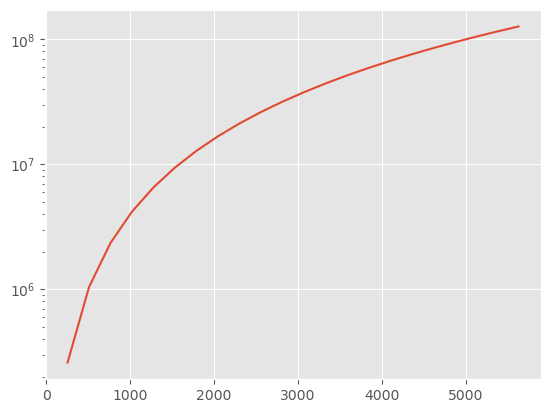

In [ ]:
plt.plot(np.array([256*n-1 for n in range(1,23)]),[lmax2npoints(256*n-1) for n in range(1,23)])
plt.yscale('log')